In [1]:
import numpy as np
import pandas as pd
import gc
import warnings
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format
warnings.filterwarnings('ignore')
df = pd.read_csv("yahoo_stock.csv")
df['Date'] = pd.to_datetime(df["Date"])
df = df.loc[: , ['Date', 'Close', 'High', 'Low', 'Open']]
df.head()

,Date,Close,High,Low,Open
0,2015-11-23,2086.59,2095.61,2081.39,2089.41
1,2015-11-24,2089.14,2094.12,2070.29,2084.42
2,2015-11-25,2088.87,2093.00,2086.30,2089.30
3,2015-11-26,2088.87,2093.00,2086.30,2089.30
4,2015-11-27,2090.11,2093.29,2084.13,2088.82


In [3]:
df.shape

(1825, 5)

In [4]:
px.line(df.sort_values(["Date"]),
        x='Date', y='Close',
        title = "Daily Close prices")

In [5]:
temp = df.set_index("Date").resample("M").mean().reset_index()
temp["year"] = temp.Date.dt.year
px.line(temp, x='Date', y='Close', color='year',title = "Monthly average close prices")

In [6]:
del temp
temp = df.copy()
temp["year"] = temp.Date.dt.year
temp["dayofweek"] = temp.Date.dt.dayofweek+1
temp = temp.groupby(["year", "dayofweek"]).mean().reset_index()
px.line(temp, x="year", y="Close" , color = "dayofweek", title = "Yearwise mean close prices for each day")

In [7]:
del temp
temp = df.copy()
temp["year"] = temp.Date.dt.year
temp["dayofweek"] = temp.Date.dt.dayofweek+1
temp = temp.groupby(["dayofweek"]).mean().reset_index()
px.line(temp, x="dayofweek", y="Close" , title = "Daywise mean close prices")

In [8]:
del temp
temp = df.copy()
temp["month"] = temp.Date.dt.month
temp = temp.groupby(["month"]).mean().reset_index()
px.line(temp, x="month", y="Close" , title = "Monthwise mean close prices")

In [9]:
del temp
temp = df.copy()
temp["month"] = temp.Date.dt.month
temp["year"] = temp.Date.dt.year
temp = temp.groupby(["year", "month"]).mean().reset_index()
px.line(temp, x="year", y="Close" , color = "month", title = "Month & Yearwise mean close prices")

In [10]:
# Time Related Features
def create_date_features(df):
    df['month'] = df.Date.dt.month.astype("int8")
    df['day_of_month'] = df.Date.dt.day.astype("int8")
    df['day_of_year'] = df.Date.dt.dayofyear.astype("int16")
    df['week_of_month'] = (df.Date.apply(lambda d: (d.day-1) // 7 + 1)).astype("int8")
    df['week_of_year'] = (df.Date.dt.weekofyear).astype("int8")
    df['day_of_week'] = (df.Date.dt.dayofweek + 1).astype("int8")
    df['year'] = df.Date.dt.year.astype("int32")
    df["is_wknd"] = (df.Date.dt.weekday // 4).astype("int8")
    df["quarter"] = df.Date.dt.quarter.astype("int8")
    df['is_month_start'] = df.Date.dt.is_month_start.astype("int8")
    df['is_month_end'] = df.Date.dt.is_month_end.astype("int8")
    df['is_quarter_start'] = df.Date.dt.is_quarter_start.astype("int8")
    df['is_quarter_end'] = df.Date.dt.is_quarter_end.astype("int8")
    df['is_year_start'] = df.Date.dt.is_year_start.astype("int8")
    df['is_year_end'] = df.Date.dt.is_year_end.astype("int8")
    # 0: Winter - 1: Spring - 2: Summer - 3: Fall
    df["season"] = np.where(df.month.isin([12,1,2]), 0, 1)
    df["season"] = np.where(df.month.isin([6,7,8]), 2, df["season"])
    df["season"] = pd.Series(np.where(df.month.isin([9, 10, 11]), 3, df["season"])).astype("int8")
    return df


In [11]:
temp = create_date_features(df)
temp.head()

,Date,Close,High,Low,Open,month,day_of_month,day_of_year,week_of_month,week_of_year,day_of_week,year,is_wknd,quarter,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,season
0,2015-11-23,2086.59,2095.61,2081.39,2089.41,11,23,327,4,48,1,2015,0,4,0,0,0,0,0,0,3
1,2015-11-24,2089.14,2094.12,2070.29,2084.42,11,24,328,4,48,2,2015,0,4,0,0,0,0,0,0,3
2,2015-11-25,2088.87,2093.00,2086.30,2089.30,11,25,329,4,48,3,2015,0,4,0,0,0,0,0,0,3
3,2015-11-26,2088.87,2093.00,2086.30,2089.30,11,26,330,4,48,4,2015,0,4,0,0,0,0,0,0,3
4,2015-11-27,2090.11,2093.29,2084.13,2088.82,11,27,331,4,48,5,2015,1,4,0,0,0,0,0,0,3


In [12]:
def AB_Test(dataframe, group, target):

    # Packages
    from scipy.stats import shapiro
    import scipy.stats as stats

    # Split A/B
    groupA = dataframe[dataframe[group] == 1][target]
    groupB = dataframe[dataframe[group] == 0][target]

    # Assumption: Normality
    ntA = shapiro(groupA)[1] < 0.05
    ntB = shapiro(groupB)[1] < 0.05
    # H0: Distribution is Normal! - False
    # H1: Distribution is not Normal! - True

    if (ntA == False) & (ntB == False): # "H0: Normal Distribution"
        # Parametric Test
        # Assumption: Homogeneity of variances
        leveneTest = stats.levene(groupA, groupB)[1] < 0.05
        # H0: Homogeneity: False
        # H1: Heterogeneous: True

        if leveneTest == False:
            # Homogeneity
            ttest = stats.ttest_ind(groupA, groupB, equal_var=True)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
        else:
            # Heterogeneous
            ttest = stats.ttest_ind(groupA, groupB, equal_var=False)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
    else:
        # Non-Parametric Test
        ttest = stats.mannwhitneyu(groupA, groupB)[1]
        # H0: M1 == M2 - False
        # H1: M1 != M2 - True

    # Result
    temp = pd.DataFrame({
        "AB Hypothesis":[ttest < 0.05],
        "p-value":[ttest]
    })
    temp["Test Type"] = np.where((ntA == False) & (ntB == False), "Parametric", "Non-Parametric")
    temp["AB Hypothesis"] = np.where(temp["AB Hypothesis"] == False, "Fail to Reject H0", "Reject H0")
    temp["Comment"] = np.where(temp["AB Hypothesis"] == "Fail to Reject H0", "A/B groups are similar!", "A/B groups are not similar!")
    temp["Feature"] = group
    temp["GroupA_mean"] = groupA.mean()
    temp["GroupB_mean"] = groupB.mean()
    temp["GroupA_median"] = groupA.median()
    temp["GroupB_median"] = groupB.median()

    # Columns
    if (ntA == False) & (ntB == False):
        temp["Homogeneity"] = np.where(leveneTest == False, "Yes", "No")
        temp = temp[["Feature","Test Type", "Homogeneity","AB Hypothesis", "p-value", "Comment", "GroupA_mean", "GroupB_mean", "GroupA_median", "GroupB_median"]]
    else:
        temp = temp[["Feature","Test Type","AB Hypothesis", "p-value", "Comment", "GroupA_mean", "GroupB_mean", "GroupA_median", "GroupB_median"]]


    print("# A/B Testing Hypothesis")
    print("H0: A == B")
    print("H1: A != B", "\n")

    return temp

In [13]:
AB_Test(dataframe=temp[temp.Close.notnull()], group = 'is_wknd', target = "Close")

# A/B Testing Hypothesis
H0: A == B
H1: A != B 



,Feature,Test Type,AB Hypothesis,p-value,Comment,GroupA_mean,GroupB_mean,GroupA_median,GroupB_median
0,is_wknd,Non-Parametric,Fail to Reject H0,0.95,A/B groups are similar!,2647.79,2647.91,2683.34,2683.96


In [14]:
AB_Test(dataframe=temp[temp.Close.notnull()], group = 'is_month_start', target = "Close")

# A/B Testing Hypothesis
H0: A == B
H1: A != B 



,Feature,Test Type,AB Hypothesis,p-value,Comment,GroupA_mean,GroupB_mean,GroupA_median,GroupB_median
0,is_month_start,Non-Parametric,Fail to Reject H0,0.94,A/B groups are similar!,2639.61,2648.14,2675.64,2683.34


In [15]:
AB_Test(dataframe=temp[temp.Close.notnull()], group = 'is_month_end', target = "Close")

# A/B Testing Hypothesis
H0: A == B
H1: A != B 



,Feature,Test Type,AB Hypothesis,p-value,Comment,GroupA_mean,GroupB_mean,GroupA_median,GroupB_median
0,is_month_end,Non-Parametric,Fail to Reject H0,0.92,A/B groups are similar!,2638.65,2648.17,2688.86,2683.34


In [16]:
AB_Test(dataframe=temp[temp.Close.notnull()], group = 'is_quarter_end', target = "Close")

# A/B Testing Hypothesis
H0: A == B
H1: A != B 



,Feature,Test Type,AB Hypothesis,p-value,Comment,GroupA_mean,GroupB_mean,GroupA_median,GroupB_median
0,is_quarter_end,Non-Parametric,Fail to Reject H0,0.74,A/B groups are similar!,2620.02,2648.16,2612.73,2683.34


In [17]:
AB_Test(dataframe=temp[temp.Close.notnull()], group = 'is_quarter_start', target = "Close")

# A/B Testing Hypothesis
H0: A == B
H1: A != B 



,Feature,Test Type,AB Hypothesis,p-value,Comment,GroupA_mean,GroupB_mean,GroupA_median,GroupB_median
0,is_quarter_start,Non-Parametric,Fail to Reject H0,0.74,A/B groups are similar!,2618.31,2648.18,2580.12,2683.34


In [18]:
AB_Test(dataframe=temp[temp.Close.notnull()], group = 'is_year_start', target = "Close")

# A/B Testing Hypothesis
H0: A == B
H1: A != B 



,Feature,Test Type,AB Hypothesis,p-value,Comment,GroupA_mean,GroupB_mean,GroupA_median,GroupB_median
0,is_year_start,Non-Parametric,Fail to Reject H0,0.48,A/B groups are similar!,2538.80,2648.16,2506.85,2683.34


In [19]:
AB_Test(dataframe=temp[temp.Close.notnull()], group = 'is_year_end', target = "Close")

# A/B Testing Hypothesis
H0: A == B
H1: A != B 



,Feature,Test Type,AB Hypothesis,p-value,Comment,GroupA_mean,GroupB_mean,GroupA_median,GroupB_median
0,is_year_end,Non-Parametric,Fail to Reject H0,0.48,A/B groups are similar!,2538.80,2648.16,2506.85,2683.34


In [20]:
#Dropping features as they do not show two groups are significantly different from each other
temp = temp.drop(labels=['is_wknd', 'is_month_start', 'is_month_end', 'is_quarter_start', 'is_quarter_end',
                        'is_year_start', 'is_year_end'], axis=1)
temp.head()

,Date,Close,High,Low,Open,month,day_of_month,day_of_year,week_of_month,week_of_year,day_of_week,year,quarter,season
0,2015-11-23,2086.59,2095.61,2081.39,2089.41,11,23,327,4,48,1,2015,4,3
1,2015-11-24,2089.14,2094.12,2070.29,2084.42,11,24,328,4,48,2,2015,4,3
2,2015-11-25,2088.87,2093.00,2086.30,2089.30,11,25,329,4,48,3,2015,4,3
3,2015-11-26,2088.87,2093.00,2086.30,2089.30,11,26,330,4,48,4,2015,4,3
4,2015-11-27,2090.11,2093.29,2084.13,2088.82,11,27,331,4,48,5,2015,4,3


In [21]:
import seaborn as sns
import math

from scipy.signal import periodogram
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess, Fourier

In [22]:
def seasonal_plot(X, y, period, freq, ax=None):
    """
    Function to plot seasonality of time series.
    """
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

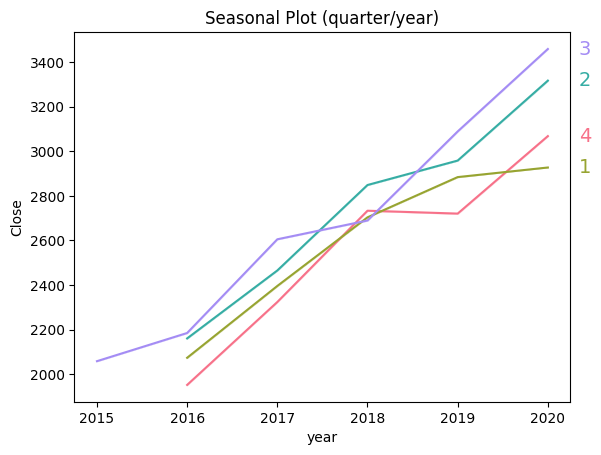

In [23]:
seasonal_plot(temp, y="Close", period="quarter", freq="year");

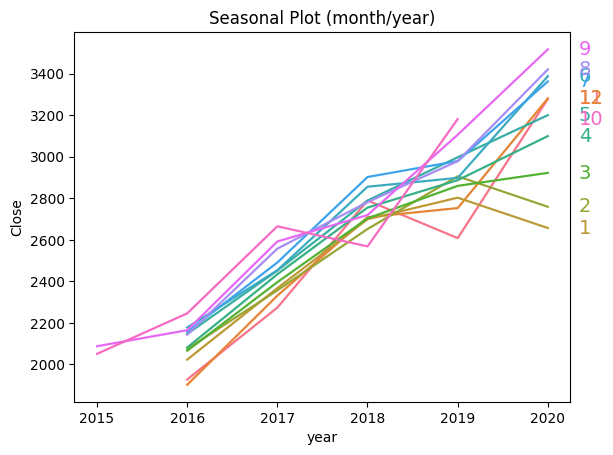

In [24]:
seasonal_plot(temp, y="Close", period="month", freq="year");

In [25]:
def plot_periodogram(ts, detrend='linear', ax=None):
    """
    Function to plot time series for identifing the dominant periods (or frequencies).
    """
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

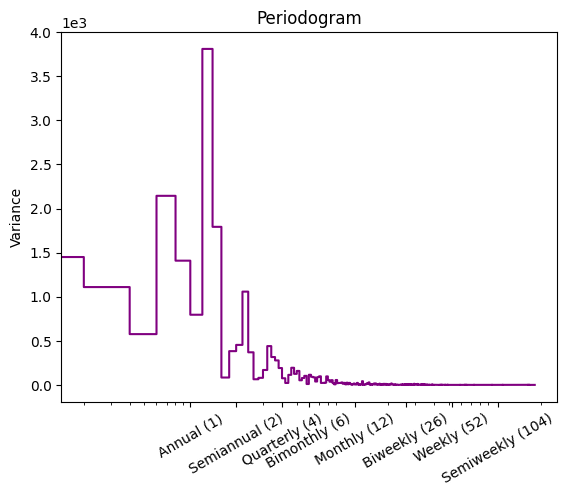

In [26]:
plot_periodogram(temp.Close);

In [27]:
fourier = CalendarFourier(freq = 'Y', order = 3)
dp = DeterministicProcess(index = temp.Date,
                          order = 1,
                          seasonal = False,
                          constant = False,
                          additional_terms = [fourier],
                          drop = True)
time = dp.in_sample()

time = time.reset_index()

print(time.shape)

temp_join = pd.merge(temp, time, how='inner', left_on='Date', right_on='Date')
print(temp_join.shape)

temp_join.head()

(1825, 8)
(1825, 21)


,Date,Close,High,Low,Open,month,day_of_month,day_of_year,week_of_month,week_of_year,day_of_week,year,quarter,season,trend,"sin(1,freq=A-DEC)","cos(1,freq=A-DEC)","sin(2,freq=A-DEC)","cos(2,freq=A-DEC)","sin(3,freq=A-DEC)","cos(3,freq=A-DEC)"
0,2015-11-23,2086.59,2095.61,2081.39,2089.41,11,23,327,4,48,1,2015,4,3,1.00,-0.62,0.78,-0.97,0.23,-0.90,-0.43
1,2015-11-24,2089.14,2094.12,2070.29,2084.42,11,24,328,4,48,2,2015,4,3,2.00,-0.61,0.79,-0.97,0.26,-0.92,-0.38
2,2015-11-25,2088.87,2093.00,2086.30,2089.30,11,25,329,4,48,3,2015,4,3,3.00,-0.59,0.80,-0.96,0.29,-0.94,-0.33
3,2015-11-26,2088.87,2093.00,2086.30,2089.30,11,26,330,4,48,4,2015,4,3,4.00,-0.58,0.81,-0.95,0.33,-0.96,-0.28
4,2015-11-27,2090.11,2093.29,2084.13,2088.82,11,27,331,4,48,5,2015,4,3,5.00,-0.57,0.82,-0.93,0.36,-0.97,-0.23


In [28]:
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.preprocessing.sequence import TimeseriesGenerator

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

In [29]:
temp_join = temp_join.set_index(['Date'])
temp_join.head(3)

,Close,High,Low,Open,month,day_of_month,day_of_year,week_of_month,week_of_year,day_of_week,year,quarter,season,trend,"sin(1,freq=A-DEC)","cos(1,freq=A-DEC)","sin(2,freq=A-DEC)","cos(2,freq=A-DEC)","sin(3,freq=A-DEC)","cos(3,freq=A-DEC)"
Date,,,,,,,,,,,,,,,,,,,,
2015-11-23,2086.59,2095.61,2081.39,2089.41,11,23,327,4,48,1,2015,4,3,1.00,-0.62,0.78,-0.97,0.23,-0.90,-0.43
2015-11-24,2089.14,2094.12,2070.29,2084.42,11,24,328,4,48,2,2015,4,3,2.00,-0.61,0.79,-0.97,0.26,-0.92,-0.38
2015-11-25,2088.87,2093.00,2086.30,2089.30,11,25,329,4,48,3,2015,4,3,3.00,-0.59,0.80,-0.96,0.29,-0.94,-0.33


In [30]:
temp_join.shape

(1825, 20)

In [31]:
target = temp_join.iloc[: , 0]
features = temp_join.iloc[: , 1:]

target.shape, features.shape

((1825,), (1825, 19))

In [32]:
target.head(3)

Date
2015-11-23   2086.59
2015-11-24   2089.14
2015-11-25   2088.87
Name: Close, dtype: float64

In [33]:
features.head(3)

,High,Low,Open,month,day_of_month,day_of_year,week_of_month,week_of_year,day_of_week,year,quarter,season,trend,"sin(1,freq=A-DEC)","cos(1,freq=A-DEC)","sin(2,freq=A-DEC)","cos(2,freq=A-DEC)","sin(3,freq=A-DEC)","cos(3,freq=A-DEC)"
Date,,,,,,,,,,,,,,,,,,,
2015-11-23,2095.61,2081.39,2089.41,11,23,327,4,48,1,2015,4,3,1.00,-0.62,0.78,-0.97,0.23,-0.90,-0.43
2015-11-24,2094.12,2070.29,2084.42,11,24,328,4,48,2,2015,4,3,2.00,-0.61,0.79,-0.97,0.26,-0.92,-0.38
2015-11-25,2093.00,2086.30,2089.30,11,25,329,4,48,3,2015,4,3,3.00,-0.59,0.80,-0.96,0.29,-0.94,-0.33


In [34]:
x_train, x_test, y_train, y_test = train_test_split(features,
                                                    target,
                                                    test_size=0.10,
                                                    random_state=123456,
                                                    shuffle=False)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1642, 19), (183, 19), (1642,), (183,))

In [35]:
tf.random.set_seed(123)

In [36]:
scaler = MinMaxScaler(feature_range=(-1, 0))

train_pre_scaled = pd.concat([y_train, x_train], axis=1)
test_pre_scaled = pd.concat([y_test, x_test], axis=1)

# train_pre_scaled = train_pre_scaled.set_index(['Date'])
# test_pre_scaled = test_pre_scaled.set_index(['Date'])

train_scaled = scaler.fit_transform(train_pre_scaled)
test_scaled = scaler.transform(test_pre_scaled)

In [37]:
x_train_scaled, y_train_scaled = train_scaled[: , 1:], train_scaled[: , 0]
x_test_scaled, y_test_scaled = test_scaled[: , 1:], test_scaled[: , 0]

x_train_scaled.shape, x_test_scaled.shape, y_train_scaled.shape, y_test_scaled.shape

((1642, 19), (183, 19), (1642,), (183,))

In [38]:
# Normalize the data
scaler = MinMaxScaler()
df['Close'] = scaler.fit_transform(df['Close'].values.reshape(-1, 1))

train_size = int(len(df) * 0.8)
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

# Create sequences for LSTM training
def create_sequences(df, seq_length):
    sequences = []
    for i in range(len(df) - seq_length):
        sequence = df[i:i+seq_length]
        target = df.iloc[i+seq_length]['Close']
        sequences.append((sequence, target))
    return sequences

sequence_length = 10  # You can adjust this value
train_sequences = create_sequences(train_df, sequence_length)
test_sequences = create_sequences(test_df, sequence_length)

# Convert sequences to numpy arrays
X_train = np.array([seq[0]['Close'].values for seq in train_sequences])
y_train = np.array([seq[1] for seq in train_sequences])
X_test = np.array([seq[0]['Close'].values for seq in test_sequences])
y_test = np.array([seq[1] for seq in test_sequences])

In [39]:
# Build the LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(sequence_length, 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

# Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Inverse transform the predictions to get actual values
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)

Epoch 1/50
46/46 [==============================] - 8s 14ms/step - loss: 0.0799
Epoch 2/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0019
Epoch 3/50
46/46 [==============================] - 1s 14ms/step - loss: 3.3849e-04
Epoch 4/50
46/46 [==============================] - 1s 12ms/step - loss: 2.8169e-04
Epoch 5/50
46/46 [==============================] - 1s 13ms/step - loss: 2.6779e-04
Epoch 6/50
46/46 [==============================] - 1s 13ms/step - loss: 2.6567e-04
Epoch 7/50
46/46 [==============================] - 1s 15ms/step - loss: 2.6175e-04
Epoch 8/50
46/46 [==============================] - 1s 17ms/step - loss: 2.5903e-04
Epoch 9/50
46/46 [==============================] - 1s 16ms/step - loss: 2.6078e-04
Epoch 10/50
46/46 [==============================] - 1s 13ms/step - loss: 2.5145e-04
Epoch 11/50
46/46 [==============================] - 1s 16ms/step - loss: 2.5882e-04
Epoch 12/50
46/46 [==============================] - 1s 17ms/step - loss: 2.5247e-

In [40]:
# Calculating the RMSE on the test set
rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
print(f"Root Mean Squared Error (RMSE) on test set: {rmse}")

Root Mean Squared Error (RMSE) on test set: 3170.170059380604


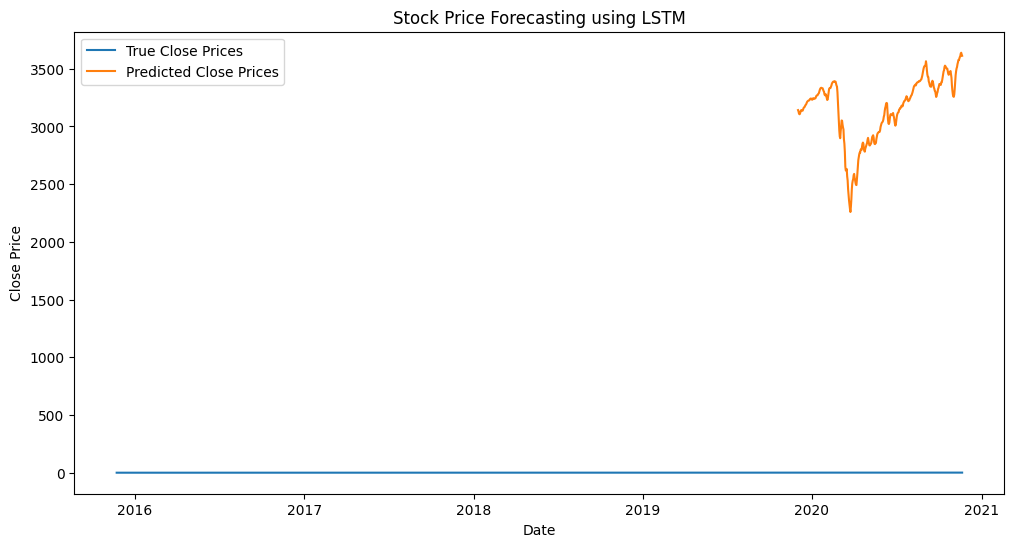

In [41]:
# Plotting the predictions of the model
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Close'], label='True Close Prices')
plt.plot(test_df['Date'][sequence_length:], test_predictions, label='Predicted Close Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Stock Price Forecasting using LSTM')
plt.legend()
plt.show()

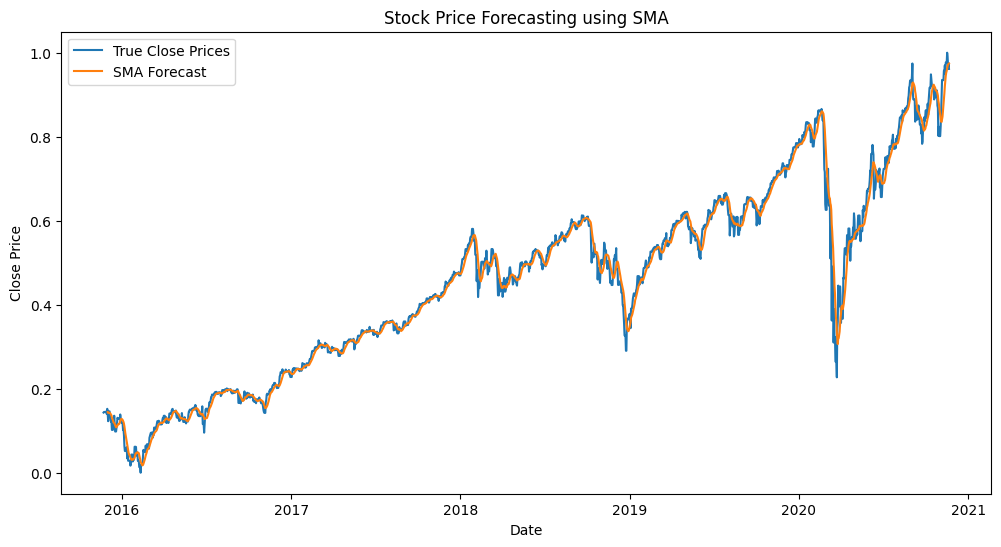

In [42]:
# Simple Moving Average (SMA) Model
def sma_forecast(data, window_size):
    return data['Close'].rolling(window=window_size).mean()

window_size = 10  # Adjust this value as needed
df['SMA Forecast'] = sma_forecast(df, window_size)

# Plot the SMA forecast
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Close'], label='True Close Prices')
plt.plot(df['Date'], df['SMA Forecast'], label='SMA Forecast')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Stock Price Forecasting using SMA')
plt.legend()
plt.show()


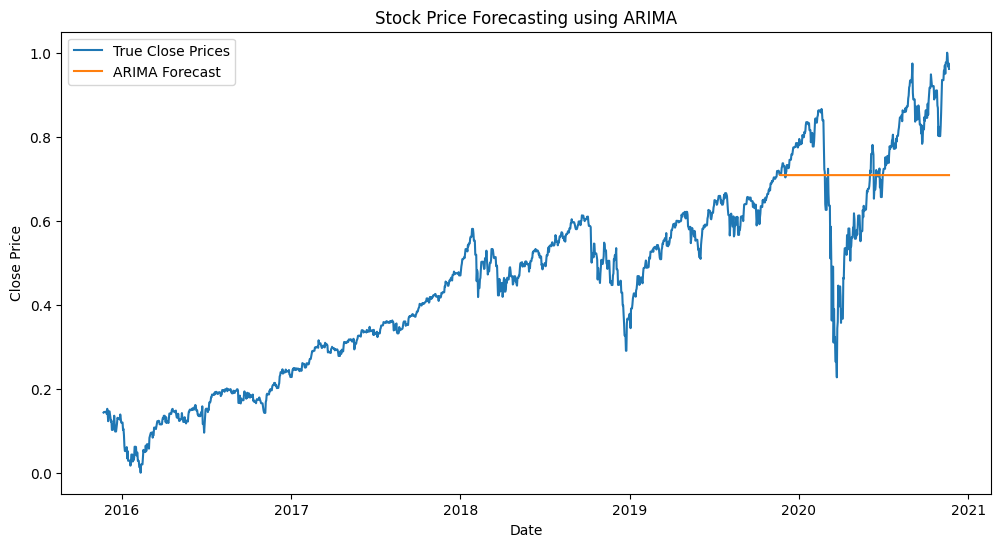

In [43]:
import statsmodels.api as sm

# Fit ARIMA model
model_arima = sm.tsa.ARIMA(train_df['Close'], order=(5,1,0))
results_arima = model_arima.fit()

# Forecast using ARIMA model
forecast_arima = results_arima.forecast(steps=len(test_df))

# Plot the ARIMA forecast
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Close'], label='True Close Prices')
plt.plot(test_df['Date'], forecast_arima, label='ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Stock Price Forecasting using ARIMA')
plt.legend()
plt.show()


12/12 [==============================] - 0s 3ms/step


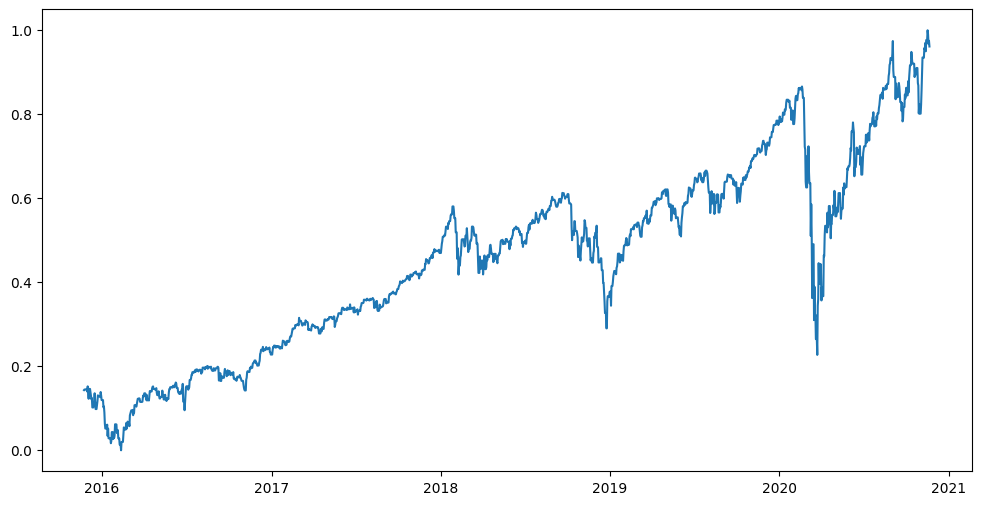

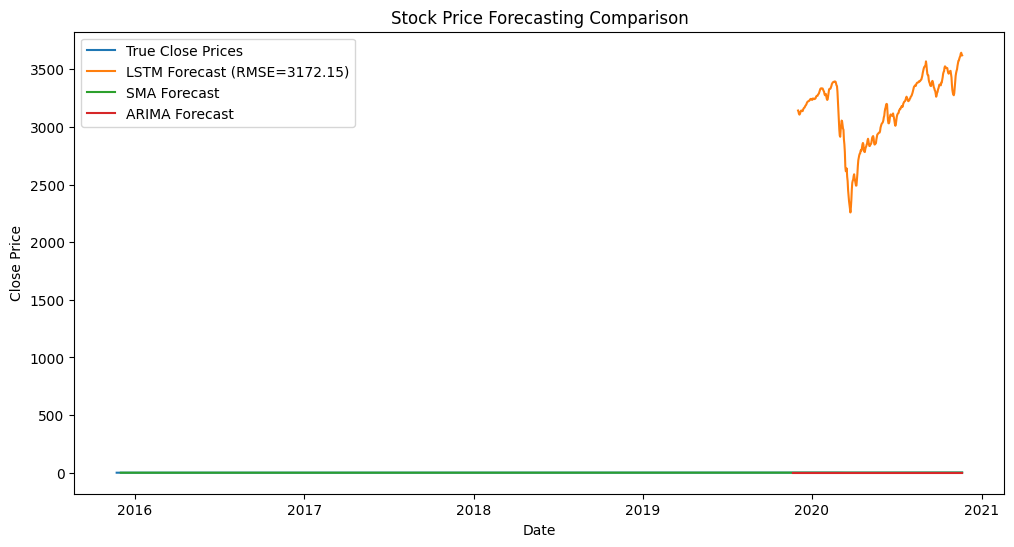

In [44]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import statsmodels.api as sm

# Load the dataset
data = pd.read_csv('yahoo_stock.csv')

# Convert the 'Date' column to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Sort the data by date
data = data.sort_values('Date')

# Use 'Close' prices for forecasting
data = data[['Date', 'Close']]

# Normalize the data
scaler = MinMaxScaler()
data['Close'] = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

# Split the data into training and testing sets
train_size = int(len(data) * 0.8)
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

# Create sequences for LSTM training
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequence = data[i:i+seq_length]
        target = data.iloc[i+seq_length]['Close']
        sequences.append((sequence, target))
    return sequences

sequence_length = 10  # You can adjust this value
train_sequences = create_sequences(train_data, sequence_length)
test_sequences = create_sequences(test_data, sequence_length)

# Convert sequences to numpy arrays
X_train = np.array([seq[0]['Close'].values for seq in train_sequences])
y_train = np.array([seq[1] for seq in train_sequences])
X_test = np.array([seq[0]['Close'].values for seq in test_sequences])
y_test = np.array([seq[1] for seq in test_sequences])

# Build the LSTM model
lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(sequence_length, 1)),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the LSTM model
lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

# Make predictions using LSTM
train_predictions_lstm = lstm_model.predict(X_train)
test_predictions_lstm = lstm_model.predict(X_test)

# Inverse transform the LSTM predictions to get actual values
train_predictions_lstm = scaler.inverse_transform(train_predictions_lstm)
test_predictions_lstm = scaler.inverse_transform(test_predictions_lstm)

# Calculate RMSE for LSTM on the test set
rmse_lstm = np.sqrt(mean_squared_error(y_test, test_predictions_lstm))

# Simple Moving Average (SMA) Model
def sma_forecast(data, window_size):
    return data['Close'].rolling(window=window_size).mean()

window_size = 10  # Adjust this value as needed
data['SMA Forecast'] = sma_forecast(data, window_size)

# Autoregressive Integrated Moving Average (ARIMA) Model
# Fit ARIMA model
model_arima = sm.tsa.ARIMA(train_data['Close'], order=(5,1,0))
results_arima = model_arima.fit()

# Forecast using ARIMA model
forecast_arima = results_arima.forecast(steps=len(test_data))

# Plot the forecasts
plt.figure(figsize=(12, 6))

# True Close Prices
plt.plot(data['Date'], data['Close'], label='True Close Prices')

# Calculate RMSE for LSTM on the test set
rmse_lstm = np.sqrt(mean_squared_error(y_test, test_predictions_lstm))

# Get the dates for the test set
test_dates = test_data['Date'].values[sequence_length:]

# Plot the forecasts
plt.figure(figsize=(12, 6))

# True Close Prices
plt.plot(data['Date'], data['Close'], label='True Close Prices')

# LSTM Forecast (shifted to align with dates)
plt.plot(test_dates, test_predictions_lstm, label=f'LSTM Forecast (RMSE={rmse_lstm:.2f})')

# SMA Forecast
plt.plot(data['Date'], data['SMA Forecast'], label='SMA Forecast')

# ARIMA Forecast
plt.plot(test_data['Date'], forecast_arima, label='ARIMA Forecast')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Stock Price Forecasting Comparison')
plt.legend()
plt.show()

In [48]:
# Calculate RMSE for LSTM on the test set
rmse_lstm = np.sqrt(mean_squared_error(y_test, test_predictions_lstm))

# Calculate RMSE for SMA on the test set
test_predictions_sma = sma_forecast(test_data, window_size)[sequence_length:].values
rmse_sma = np.sqrt(mean_squared_error(y_test, test_predictions_sma))

# Forecast using ARIMA model for the same number of steps as in the test dataset
rmse_arima = forecast_arima[:len(test_data)]
rmse_arima = rmse_arima.iloc[0]

# Print RMSE values for all models
print(f"RMSE for LSTM: {rmse_lstm:.2f}")
print(f"RMSE for SMA: {rmse_sma:.2f}")
print(f"RMSE for ARIMA: {rmse_arima:.2f}")

# Compare the models
if rmse_lstm < rmse_sma and rmse_lstm < rmse_arima:
    print("LSTM is the best model.")
elif rmse_sma < rmse_lstm and rmse_sma < rmse_arima:
    print("SMA is the best model.")
else:
    print("ARIMA is the best model.")


RMSE for LSTM: 3172.15
RMSE for SMA: 0.04
RMSE for ARIMA: 0.71
SMA is the best model.
